## Demo 6 - movie poster classification

Multi-label (meaning that there is more than one "true" label) classification of movie poster images by genre.

In [1]:
import os
import sys
from skimage import io
from torch import nn
import torch
import numpy as np
import random
import pandas as pd

### Load the data

We use a PyTorch `Dataset` to represent the data, which means we must implement `__init__`, `__len__` and `__getitem__`.  For efficiency's sake, we ideally want to load the image data (movie posters and their genre classifications) and represent them as a `Tensor` in memory.

The movie posters had to be converted to images of the same size and colour channels.  The resizing can be done inside Python but is slow, so they were converted on-disk using command-line tools. The colour channels are more efficient than resizing in Python, so that was done in Python.

Note that we need to permute the dimensions of the `Tensor` we create from `skimage` NumPy arrays. The latter represent the colour channels (three, for red-green-blue) as the innermost dimension (the fourth dimension, or dimension 3, meaning that pixels are represented as an array of three colour values).  The convolutional layers in PyTorch require the colour channel to be the second dimension (after the batch dimension, meaning that the image is represented as three overlapping images, one for each colour, where each pixel is a single value).  You need to use `Tensor.permute` not `Tensor.view`---the latter just redraws the "boxes" inside the array, it doesn't rearrange the data for a different order of dimensions.

In [2]:
SEED = 23

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [3]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

In [4]:
from torch.utils.data import Dataset
from skimage import transform
from skimage import color

class MoviePosterDataset(Dataset):
    def __init__(self, csvfile, imagedir, device=device):
        self.posterlist = pd.read_csv(csvfile)
        self.imagedir = imagedir
        
        imageids = list(self.posterlist["Id"])
        imagefiles = ["{}/{}.jpg".format(self.imagedir, x) for x in imageids]
        images = [np.array(io.imread(x)) for x in imagefiles]
        images = np.array([color.gray2rgb(x) if len(x.shape) < 3 else x for x in images])
        
        truths = self.posterlist[self.posterlist.columns[2:]]
        self.truths = torch.Tensor(truths.to_numpy())
    
        tns = torch.from_numpy(images)
        self.images = tns.permute(0, 3, 1, 2)
        
        if device != "cpu":
            self.device = torch.device(device)
            self.images = self.images.to(self.device)
            self.truths = self.truths.to(self.device)
        
    def __len__(self):
        return len(self.posterlist)
    
    def __getitem__(self, idx):            
        truths = self.truths[idx]
        images = self.images[idx]
        
        return images, truths

We keep the `Tensor` on the CPU because of memory limitations created by sticking to one GPU (which only has 10GB of space to itself).  We will move it to the GPU in batches instead.

In [5]:
mpd = MoviePosterDataset("Multi_Label_dataset/train.csv", 
                         "Multi_Label_dataset/ImageSmaller", device="cpu")
print("Finished loading the dataset.")

Finished loading the dataset.


There are 7254 poster images and all the images have been converted to a shape of (3, 300, 450). There are 25 movie labels.

In [6]:
mpd.images.shape, mpd.truths.shape

(torch.Size([7254, 3, 300, 450]), torch.Size([7254, 25]))

### 

Defining a model with convolutional layers for images is technically a lot easier than defining an RNN-based model for human language.  The `Conv2d` layer automatically moves a 5x5 filter across the entire image, no effort required to manage padding and packing and unpacking and sequence issues. We do have to flatten the output of the `MaxPool2d` layer to feed it to the subsequent `Linear` layers.  The output of the model comes from `Sigmoid` over the number of classes, so that we have a binary classification for the 25 separate movie labels.  

###  Model parameters

X = Batch size

Layer 1
* First convolutional layer: Size changes from `[X, 3, 300, 450]` to `[X, 16, 300, 450]`.
* Dropout: 0.8
* First pooling layer: Size changes from `[X, 16, 300, 450]` to `[X, 16, 150, 225]`.

Layer 2
* Second convolutional layer: Size changes from `[X, 16, 150, 225]` to `[X, 32, 150, 225]`.
* Dropout: 0.25
* Second pooling layer: `[X, 32, 75, 112]` to `[X, 32, 75, 112]`.

Layer 3
* Third convolutional layer: Size changes from `[X, 32, 75, 112]` to `[X, 64, 75, 112]`.
* Dropout: 0.25
* Third pooling layer: Size changes from `[X, 64, 75, 112]` to `[X, 64, 37, 56]`.


After training the model using 3 layers, the model starts to overfit; it's learning to recognize specific images in the training set rather than generalizing. Adding dropout to all the layers did not help to avoid overfitting. 

The  model with the lowest loss was trained using 3 layers, a dropout of 0.8 at the first layer and a dropout of 0.25 for the others. However, the model starts to overfit after 5 epochs; the validation keeps increasing while the training loss stays close to 0.

![pl1](/img/3l_lr0001.png "Plot 1")
3 layers, dropout 0.8 for input layer, 0.25 for the rest, learning rate: 0.0001

Using the same dropout, but adding a 4th layer produces similar results as only using 3 layers, but the model takes longer (10 epochs) before it starts to overfit. The model with 3 layers performed slightly better so I decided to keep it like this.
![pl2](/img/4l_lr0001.png "Plot 2")
4 layers, dropout 0.8 for input layer, 0.25 for the rest, learning rate: 0.0001

Training the model using 4 layers with a higher learning rate gives a higher loss than the 3 layers and after 20 epochs, both the training and validation loss increases. Training the model with a lower learning rate, even when including dropout for all layers, causes the model to overfit.

![pl3](/img/4l_lr001.png "Plot 3")
4 layers, dropout 0.8 for input layer, 0.25 for the rest, learning rate: 0.001

In [7]:
class PosterClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()
    
        # Kernel Size: the size of the filter.
        
        # Stride: the rate at which the kernel passes over the input image. 
        # A stride of 2 moves the kernel in 2-pixel increments.
        
        # Padding : add layers of 0s to the outside of the image 
        # in order to make sure that the kernel properly passes over the edges of the image.
        # Padding should be smaller than half the kernel size
        
        self.input_dropout = nn.Dropout(0.8)
        self.dropout = nn.Dropout(dropout)
    
        # Layer 1
        self.conv1  = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5, stride=1, padding=2)
        self.bnm1 = nn.BatchNorm2d(16)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Layer 2
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32, kernel_size=5, stride=1, padding=2)
        self.bnm2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        # Layer 3
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64, kernel_size=5, stride=1, padding=2)
        self.bnm3 = nn.BatchNorm2d(64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        # Layer 4
        self.conv4 = nn.Conv2d(in_channels=64,out_channels=128, kernel_size=5, stride=1, padding=2)
        self.bnm4 = nn.BatchNorm2d(128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.relu = nn.ReLU()
        self.linear0 = nn.Linear((64*37*56), 3000)
        #self.linear0 = nn.Linear(128 * 18 * 28, 3000)
        self.tanh = nn.Tanh()    
        self.linear1 = nn.Linear(3000, 25) # 25 output classes
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input):
        # conv -> relu -> maxpool        
        # Computes the activation of the first convolution
        # X is batch size
        
        #Layer 1
        #Size changes from [X, 3, 300, 450] to [X, 16, 300, 450]
        output = self.conv1(input)
        output = self.bnm1(output)
        output = self.relu(output)
        output = self.input_dropout(output) 
        #print("Conv1", output.size())
        #Size changes from [X, 16, 300, 450] to [X, 16, 150, 225]
        output = self.maxpool1(output)
        #print("Pool1", output.size())
        
        #Layer 2
        #Size changes from [X, 16, 150, 225] to [X, 32, 150, 225]
        output = self.conv2(output)
        output = self.bnm2(output)
        output = self.relu(output)
        output = self.dropout(output)   
        #print("Conv2", output.size())
        #Size changes from [X, 32, 75, 112] to [X, 32, 75, 112]
        output = self.maxpool2(output)
        #print("Pool2", output.size())
        
        #Layer 3
        #Size changes from [X, 32, 75, 112] to [X, 64, 75, 112]
        output = self.conv3(output)
        output = self.bnm3(output)
        output = self.relu(output)
        output = self.dropout(output) 
        #print("Conv3", output.size())
        #Size changes from [X, 64, 75, 112) to [X, 64, 37, 56]
        output = self.maxpool3(output)
        #print("Pool3", output.size())
        
        #Layer 4
        #Size changes from [X, 64, 75, 112] to [X, 128, 75, 112]
        #output = self.conv4(output)
        #output = self.bnm4(output)
        #output = self.relu(output)
        #output = self.dropout(output) 
        #print("Conv4", output.size())
        #Size changes from [X, 128, 75, 112] to [X, 128, 18, 28]
        #output = self.maxpool4(output)
        #print("Pool4", output.size())
        
        #output = output.view(-1, 3*90*60)
        output = output.view(-1, 64*37*56) # output size of final pooling layer
        #output = output.view(-1, 128 * 18 * 28)
        output = self.relu(output)
        output = self.linear0(output)
        output = self.dropout(output)
        output = self.tanh(output)
        output = self.linear1(output)
        output = self.dropout(output)
        output = self.sigmoid(output)
        
        return output

### Arrange the data for the model

We're going to do a 60/40 train/test split using PyTorch's own samplers and data loaders.

In [8]:
len(mpd)

7254

In [9]:
totalindices = list(range(len(mpd)))

In [10]:
import random
import math

random.shuffle(totalindices)
splitindex = math.floor(len(mpd)*0.6)

In [11]:
splitindex

4352

## Part #1: validation data (4 points)

Adjust the code in the notebook to give a 60/20/20 train/validation/testing split of the data. Testing data is split 50/50 into test and validation sets.

In [12]:
trainingindices = totalindices[:splitindex]
testingindices_ = totalindices[splitindex:]

In [13]:
splitindex2 = math.floor(len(testingindices_)*0.5)

In [14]:
splitindex2

1451

In [15]:
testingindices = testingindices_[:splitindex2]
validationindices = testingindices_[splitindex2:]

In [16]:
trainingsampler = torch.utils.data.SubsetRandomSampler(trainingindices)
testingsampler = torch.utils.data.SubsetRandomSampler(testingindices)
validationsampler = torch.utils.data.SubsetRandomSampler(validationindices)

In [17]:
print(f'Number of training examples: {len(trainingsampler)}')
print(f'Number of validation examples: {len(validationsampler)}')
print(f'Number of testing examples: {len(testingsampler)}')

Number of training examples: 4352
Number of validation examples: 1451
Number of testing examples: 1451


In [18]:
batches = 32

In [19]:
traindl = torch.utils.data.DataLoader(mpd, batch_size=batches, 
                                      sampler=trainingsampler, pin_memory=False)
valdl = torch.utils.data.DataLoader(mpd, batch_size=batches, sampler=validationsampler, pin_memory=False)
testdl = torch.utils.data.DataLoader(mpd, sampler=testingsampler)

# Jackard Index
The size of the intersection divided by the size of the union of two label sets:
A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)

CNN for image identification applications apply the Jaccard Index measurements as a way of conceptualizing accuracy of object detection.

In [20]:
def jaccard(output, truth):
    jaccard_loss = 0.0
    for i in range(len(truth)):
            tru = [a.item() for a in truth[i]]
            out = [1.0 if index.item() > 0.5 else 0.0 for index in output[i]]
            intersection = 0.0
            union = 0.0
            for i in range(len(tru)):
                if tru[i] == out[i]:
                    intersection += 1
                union += 1
            jaccard_loss += float(intersection)/float(union)
    return jaccard_loss

In [21]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Write and run the training loop



In [22]:
model_name = "image_model"
model = PosterClassifier()

In [23]:
model

PosterClassifier(
  (input_dropout): Dropout(p=0.8, inplace=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bnm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bnm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bnm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bnm4): BatchNorm2d(128, eps=1e-05, momentu

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 398,172,745 trainable parameters


### Training the model

The model computes the loss for the training set and the validation set and saves the model with the lowest loss.

In [25]:
learning_rate= 0.0001
decay=1e-6

In [26]:
import torch.optim as optim
import time
import numpy as np

def train(train_dataloader, val_dataloader, model,epochs=3):
    torch.cuda.empty_cache()
    
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)

    criterion = nn.BCELoss()
    criterion = criterion.to(device)
    best_val_loss = 0.0
    jaccard_losses = []
    val_losses = []
    train_losses = []
    
    for epoch in range(epochs):
        start_time = time.time()
        
        # Training
        train_loss = 0.0        
        train_batches = 0
        
        for c, data in enumerate(train_dataloader):
            images, truth = data
            optimizer.zero_grad()
            output = model(images.float().to(device))
            loss = criterion(output, truth.to(device))
            train_loss += loss
            train_batches += 1.0
            loss.backward()
            optimizer.step()

        # Validation
        val_loss = 0.0        
        val_batches = 0        
        jaccard_loss = 0.0
        
        model.eval()
        for c, data in enumerate(val_dataloader):
            images, truth = data
            output = model(images.float().to(device))
            with torch.no_grad():  
                val_loss += criterion(output, truth.to(device))          
            val_batches += 1.0   
            jaccard_loss += jaccard(output, truth.to(device)) 
            
        validation_loss = val_loss/val_batches
        validation_loss = validation_loss.item()       
        training_loss = train_loss/train_batches
        training_loss = training_loss.item()
        jaccard_loss = jaccard_loss/float(batches*val_batches)
           
        val_losses.append(validation_loss)
        jaccard_losses.append(jaccard_loss)
        train_losses.append(training_loss)       
        
        # save best model
        if epoch == 0:
            best_val_loss = validation_loss        
        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            print("Best loss so far!")
            torch.save(model.state_dict(), model_name)
            #torch.save(model, model_name)
            
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)  
               
        
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {training_loss:.3f}')
        print(f'\t Validation Loss: {validation_loss:.3f}')
        print(f'\t Lowest Loss: {best_val_loss:.3f}')
        print(f'\t Jaccard Index: {jaccard_loss:.3f}')
        
    return val_losses, train_losses, jaccard_losses

In [27]:
val_losses, train_losses, jaccard_losses = train(traindl,valdl, model,epochs=30)

Epoch: 01 | Epoch Time: 0m 33s
	Train Loss: 0.481
	 Validation Loss: 0.247
	 Lowest Loss: 0.247
	 Jaccard Index: 0.895
Best loss so far!
Epoch: 02 | Epoch Time: 0m 48s
	Train Loss: 0.246
	 Validation Loss: 0.239
	 Lowest Loss: 0.239
	 Jaccard Index: 0.896
Best loss so far!
Epoch: 03 | Epoch Time: 0m 48s
	Train Loss: 0.239
	 Validation Loss: 0.235
	 Lowest Loss: 0.235
	 Jaccard Index: 0.898
Best loss so far!
Epoch: 04 | Epoch Time: 0m 48s
	Train Loss: 0.237
	 Validation Loss: 0.234
	 Lowest Loss: 0.234
	 Jaccard Index: 0.899
Epoch: 05 | Epoch Time: 0m 32s
	Train Loss: 0.233
	 Validation Loss: 0.236
	 Lowest Loss: 0.234
	 Jaccard Index: 0.899
Best loss so far!
Epoch: 06 | Epoch Time: 0m 47s
	Train Loss: 0.225
	 Validation Loss: 0.232
	 Lowest Loss: 0.232
	 Jaccard Index: 0.901
Epoch: 07 | Epoch Time: 0m 32s
	Train Loss: 0.208
	 Validation Loss: 0.235
	 Lowest Loss: 0.232
	 Jaccard Index: 0.900
Epoch: 08 | Epoch Time: 0m 32s
	Train Loss: 0.171
	 Validation Loss: 0.242
	 Lowest Loss: 0.232

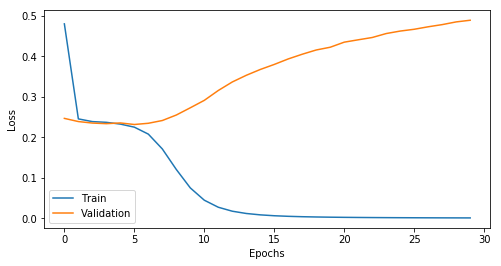

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label="Validation")
#plt.plot(jaccard_losses, label='Jaccard',linestyle='--')
plt.legend(['Train', 'Validation'])
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

### Test the model

For memory purposes, we're keeping the testing data on the CPU memory still.  We have to put the model into evaluation mode with `model.eval`, which turns off the dropout and other regularization useful in training---we want the test to represent a deterministic result of the trained model. We also test a single epoch as one big batch.

In [29]:
#trained = torch.load(model_name)
device = "cpu" # cuda out of memory
model = model.to(device) 
model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [30]:
def test(model, dataloader):
    torch.cuda.empty_cache()
    model.eval()
    criterion = nn.BCELoss()
    sumloss = 0.0
    items = 0.0
    jaccard_loss = 0.0
    
    for c, data in enumerate(dataloader):
        images, truth = data
        output = model(images.float().to(device))
        sumloss += criterion(output, truth.to(device))
        jaccard_loss += jaccard(output, truth.to(device))
        items += 1.0
        
    print(f'\t Test Loss: {sumloss/items:.3f}')
    print(f'\t Jaccard Index: {jaccard_loss/items:.3f}')

In [31]:
test(model, testdl)

	 Test Loss: 0.236
	 Jaccard Index: 0.913
